### 1.0 - Visualizando as 4 estações virtuais mais próximas da estação de Traipu

C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos\modulo3_stations_virtual.py:78: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['distances'] = df.distance(df_station)
C:\Users\Ari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos\modulo3_stations_virtual.py:131: UserWarning: Geometry is in a geograph

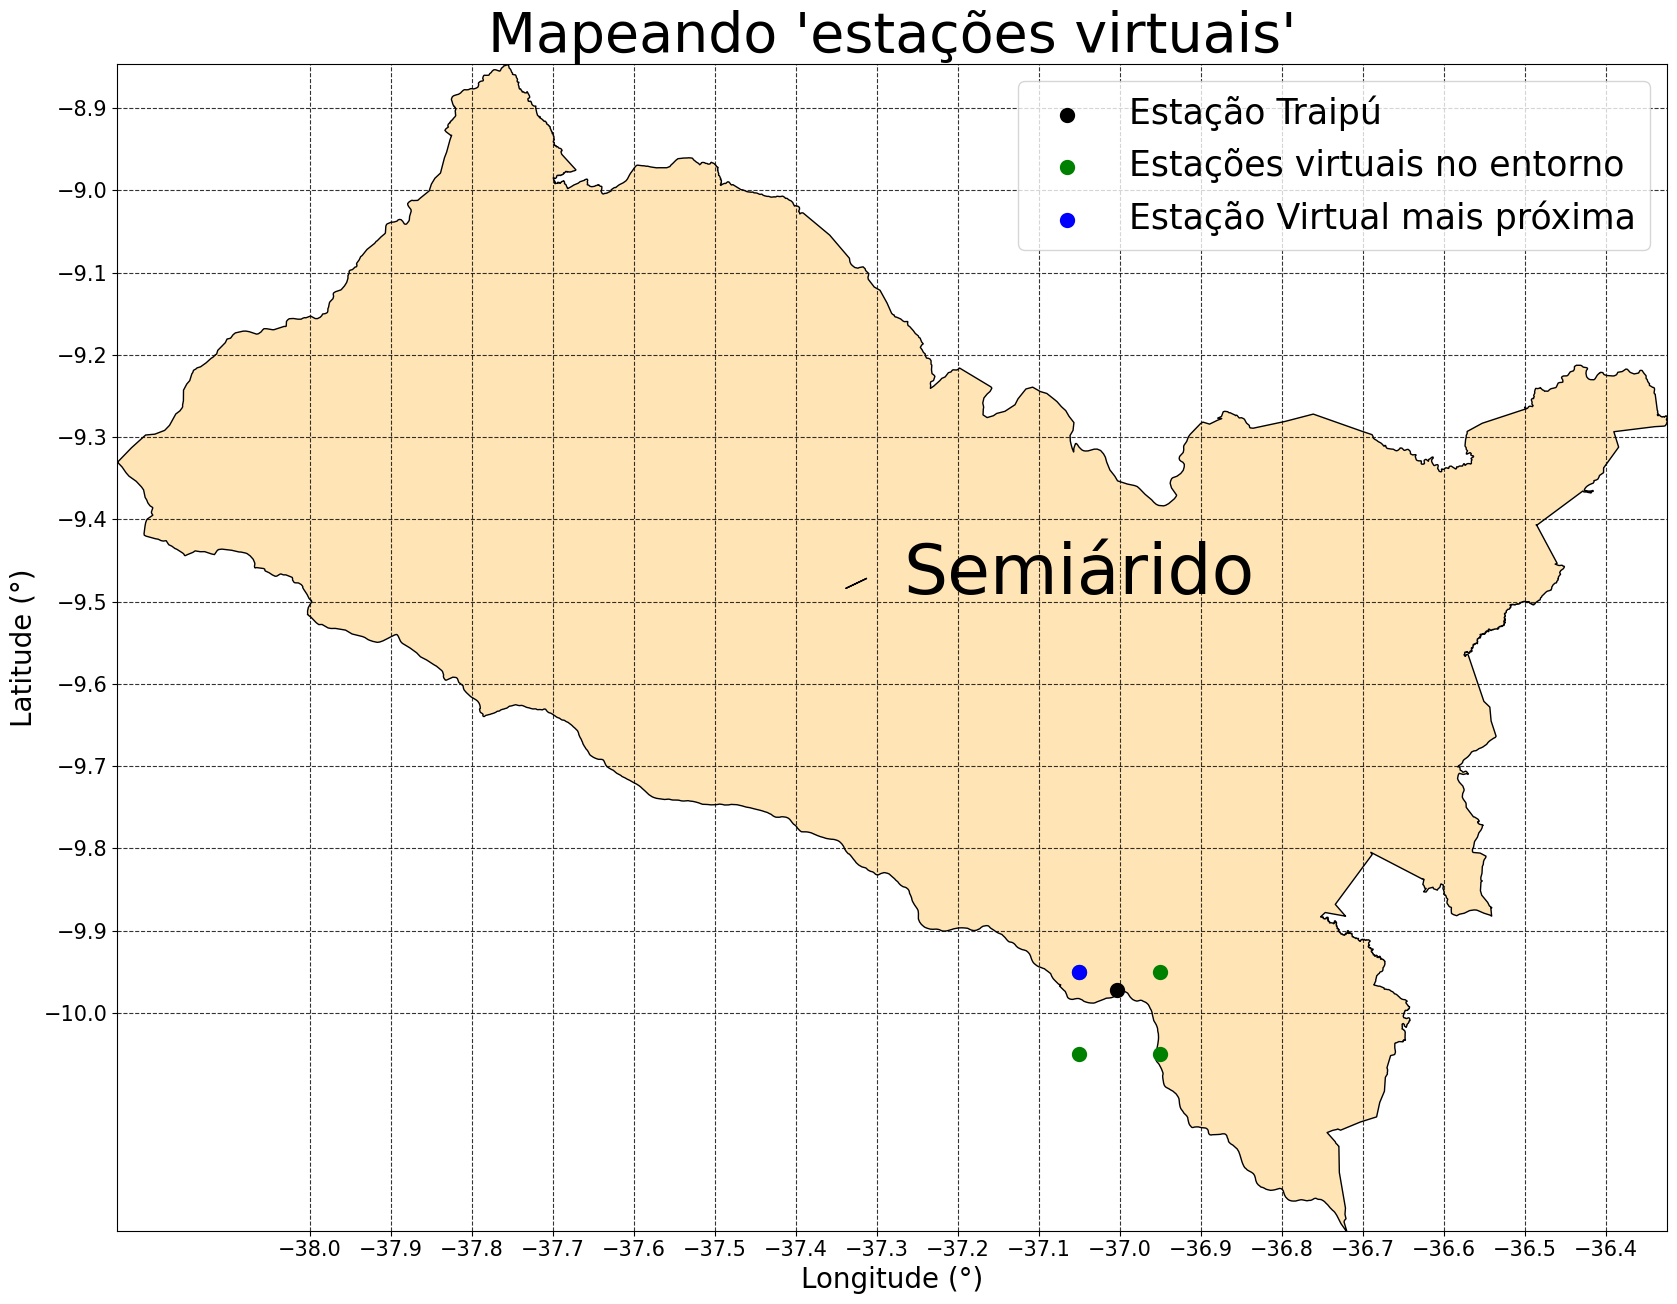

In [1]:
#Inserindo caminho da pasta onde estão os modulos que utilizaremos
import sys
sys.path.insert(0, r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos")

#Importando os módulos
from modulo3_stations_virtual import *
import modulo1_station_processing as modulo1 

#Importanddo função para unir diversas geometrias 
from shapely.ops import cascaded_union, unary_union

#Leitura rquivo região de interesse (semiarido)
semiarido = gpd.read_file(r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\semiarido_2021\semiarido_2021.shp")
semiarido = semiarido.to_crs('EPSG:4326')

#Temos os shapefiles de diversos municípios, queremos um shapefile único, com toda a delimitação da região
semiarido_union = unary_union(semiarido.geometry)
semiarido_union = gpd.GeoDataFrame(geometry = [semiarido_union], crs='EPSG:4326')

#Caminho da pasta na qual o arquivo de interesse está localizado
path = r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\DAILY_RAIN\MERGE_CPTEC_20010105.grib2"

#Realizando leitura do arquivo
df_prec = read_file_precipitation_grib(path, temporal_scaling="D") 

#Buscando por um ponto (com dados de satélite) mais próximo possível da estação de interesse
# Coordenadas estação de Traipu
coords =  Point((-37.0033, -9.9728))
station_real = gpd.GeoDataFrame(geometry=[coords]) 
stations_virtual = find_station_virtual(df_prec, station_real.geometry[0])

#Visualizando
map_stations(semiarido_union, station_real, stations_virtual, df_prec, 'Semiárido', 'Traipú') 

### 2.0 - Interpolação bilinear

In [2]:
#Lendo arquivo de uma estação qualquer, neste caso, de Traipú
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\Dados_estações\TRAIPU (1).xlsx'
df_traipu = modulo1.read_station(path)

#Selecionando lista com estações e ponto de interesse (estação Traipu)
list_stations = organizing_stations(stations_virtual)
point_coords = (-37.00330, -9.97280)

#Calculando interpolação bilinear para as coordenadas da estação de Traipu
prec_interpolation = bilinear_interpolation(point_coords, list_stations)

#Verificando valor de precipitação na estação de Traipu
prec_traipu = df_traipu[df_traipu.Data == "2001-01-05"]['Precipitação (mm)'].to_list()[0]

#Visualizando
print('Precipitação (interpolada): ', np.around(prec_interpolation, 3), " mm")
print('Precipitção (Traipu) ', prec_traipu, " mm") 

Precipitação (interpolada):  5.919  mm
Precipitção (Traipu)  6.0  mm
